In [1]:
import scanpy as sc
from utils.data_utils import drop_rare_classes
import logging
import os
from scipy.sparse import issparse
import pickle
from utils.metrics import mmd_rbf, compute_wass, transform_gpu, umap_embed, binned_KL
import anndata as ad
from torch.utils.data import DataLoader
from utils.adata_dataset import TestLabelDataset
from tqdm import tqdm

logging.basicConfig(format='[%(levelname)s:%(asctime)s] %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)


pert_split = "chron"
leiden_resol = 1.0

In [2]:
adata = sc.read_h5ad(f"/home/dfl32/project/ifm/cinemaot_data/conditional_cinemaot/{pert_split}_split/test_data_{pert_split}_split.h5ad") # shape (5902, 21710)
n_cells_before_dropping = adata.shape[0]
logger.info("Dropping classes occurring less than 1%...")
adata = drop_rare_classes(adata)
n_cells_after_dropping = adata.shape[0]
logger.info(f"Done dropping. Before dropping: {n_cells_before_dropping} cells, after dropping: {n_cells_after_dropping}")

if issparse(adata.X):
    expression_data = adata.X.toarray()
else:
    expression_data = adata.X

    # Load saved PCA model. 
save_dir = "/home/dfl32/project/ifm/projections"
save_name = f"{pert_split}_pcadim1000_numsamples10000.pickle"
save_path = os.path.join(save_dir, save_name)
logger.info(f"Loading PCA model from {save_path}...")
with open(save_path, 'rb') as f:
    pca = pickle.load(f)
    logger.info("Done.")

logger.info("PCAing ground truth data...")
pca_expression_data = transform_gpu(expression_data, pca)
logger.info("Done.")

test_dataset = TestLabelDataset(adata)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False)
umap_labels = {
    "perturbation": [],
    "cell_type": [],
    "chronicity": [],
    "combined_labels": []
}
for batch in tqdm(test_dataloader):
    # Prepare labels
    umap_labels["perturbation"].extend(batch["perturbation"])
    umap_labels["cell_type"].extend(batch["cell_type"])
    umap_labels["chronicity"].extend(batch["chronicity"])
    umap_labels["combined_labels"].extend(batch["combined_labels"])

pca_gt_adata = ad.AnnData(X=pca_expression_data) # Already PCA'd
pca_gt_adata.obs["perturbation"] = umap_labels["perturbation"]
pca_gt_adata.obs["cell_type"] = umap_labels["cell_type"]
pca_gt_adata.obs["chronicity"] = umap_labels["chronicity"]
pca_gt_adata.obs["combined_labels"] = umap_labels["combined_labels"]

/home/sh2748/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
[INFO:2024-09-15 14:50:58,444] Dropping classes occurring less than 1%...
[INFO:2024-09-15 14:50:58,499] Done dropping. Before dropping: 11160 cells, after dropping: 11017
[INFO:2024-09-15 14:50:58,810] Loading PCA model from /home/dfl32/project/ifm/projections/chron_pcadim1000_numsamples10000.pickle...
[INFO:2024-09-15 14:50:58,863] Done.
[INFO:2024-09-15 14:50:58,865] PCAing ground truth data...
[INFO:2024-09-15 14:51:00,062] Done.
100%|██████████| 111/111 [00:00<00:00, 17778.58it/s]


In [3]:
# Load UMAP model that is trained on PCA GT data
umap_model_dir = "/gpfs/radev/scratch/dijk/sh2748/calmflow_singlecell/umap_models"
umap_model_path = os.path.join(umap_model_dir, f"{pert_split}_split_umap_model.pkl")
with open(umap_model_path, 'rb') as f:
    logger.info(f"Loading UMAP model from {umap_model_path}...")
    umap_model = pickle.load(f)
    logger.info("Done.")

logger.info("Transforming PCA expression data and PCA IFM data to 2D UMAP...")
umap_pca_expression_data = umap_model.transform(pca_expression_data)
logger.info("Done.")

pca_gt_adata.obsm["X_umap"] = umap_pca_expression_data # checked

[INFO:2024-09-15 14:51:00,090] Loading UMAP model from /gpfs/radev/scratch/dijk/sh2748/calmflow_singlecell/umap_models/chron_split_umap_model.pkl...
[INFO:2024-09-15 14:51:02,061] Done.
[INFO:2024-09-15 14:51:02,062] Transforming PCA expression data and PCA IFM data to 2D UMAP...
[INFO:2024-09-15 14:51:02,145] Done.


In [4]:
pca_gt_adata

AnnData object with n_obs × n_vars = 11017 × 1000
    obs: 'perturbation', 'cell_type', 'chronicity', 'combined_labels'
    obsm: 'X_umap'

In [5]:
# Perform Leiden clustering on ground truth data
sc.pp.neighbors(pca_gt_adata, use_rep='X_umap')
sc.tl.leiden(pca_gt_adata, resolution=leiden_resol)

num_leiden_clusters = pca_gt_adata.obs['leiden'].nunique()
logger.info(f"Number of Leiden clusters: {num_leiden_clusters}")
gt_adata_save_dir = os.path.join("/gpfs/radev/scratch/dijk/sh2748/calmflow_singlecell/test_data_with_leiden_labels", pert_split,f"resol{leiden_resol}")
os.makedirs(gt_adata_save_dir, exist_ok=True)
gt_adata_save_path = os.path.join(gt_adata_save_dir, f"test_adata_with_Leiden_resol{leiden_resol}_cluster{num_leiden_clusters}.h5ad")
pca_gt_adata.write(gt_adata_save_path)

[INFO:2024-09-15 14:51:13,767] Number of Leiden clusters: 48
... storing 'perturbation' as categorical
... storing 'cell_type' as categorical
... storing 'chronicity' as categorical
... storing 'combined_labels' as categorical


/home/sh2748/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/sh2748/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


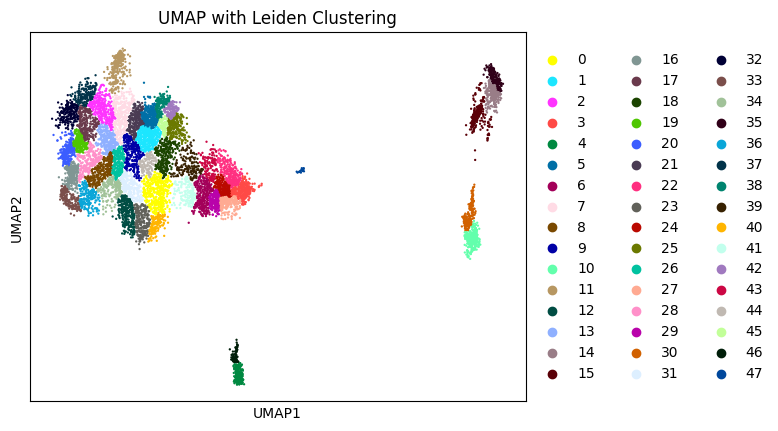

In [6]:
import matplotlib.pyplot as plt

# Visualize UMAP with Leiden coloring
sc.settings.figdir = os.path.join(gt_adata_save_dir)
sc.pl.umap(pca_gt_adata, color='leiden', title='UMAP with Leiden Clustering', save=f'_leiden_resol{leiden_resol}.png')
# Save the UMAP coordinates to a separate fil



Extracting features and labels from ground truth data...
Splitting the ground truth data into training, validation, and testing sets...
Converting data to PyTorch tensors...
Creating DataLoader for training and validation data...
Initializing the model, loss function, and optimizer...
Training the model...
Epoch [1/2000], Loss: 4.0405, Val Loss: 3.7409, Val Acc: 0.0315
Epoch [2/2000], Loss: 3.5633, Val Loss: 3.4429, Val Acc: 0.1077
Epoch [3/2000], Loss: 3.3485, Val Loss: 3.2814, Val Acc: 0.1016
Epoch [4/2000], Loss: 3.2123, Val Loss: 3.1649, Val Acc: 0.1518
Epoch [5/2000], Loss: 3.1103, Val Loss: 3.0666, Val Acc: 0.1652
Epoch [6/2000], Loss: 3.0115, Val Loss: 2.9806, Val Acc: 0.1700
Epoch [7/2000], Loss: 2.9400, Val Loss: 2.9037, Val Acc: 0.1912
Epoch [8/2000], Loss: 2.8643, Val Loss: 2.8393, Val Acc: 0.2051
Epoch [9/2000], Loss: 2.8030, Val Loss: 2.7760, Val Acc: 0.2033
Epoch [10/2000], Loss: 2.7446, Val Loss: 2.7229, Val Acc: 0.2117
Epoch [11/2000], Loss: 2.6905, Val Loss: 2.6723, Va

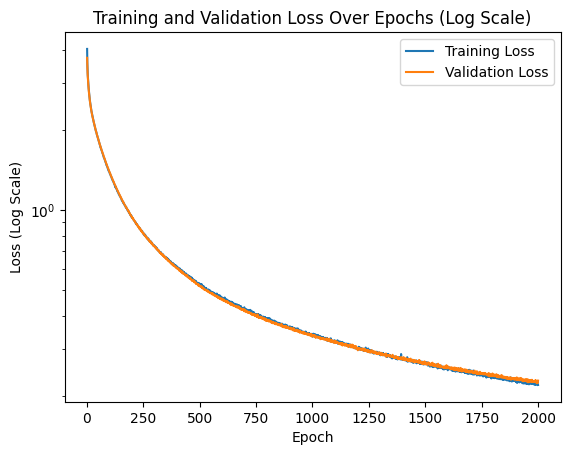

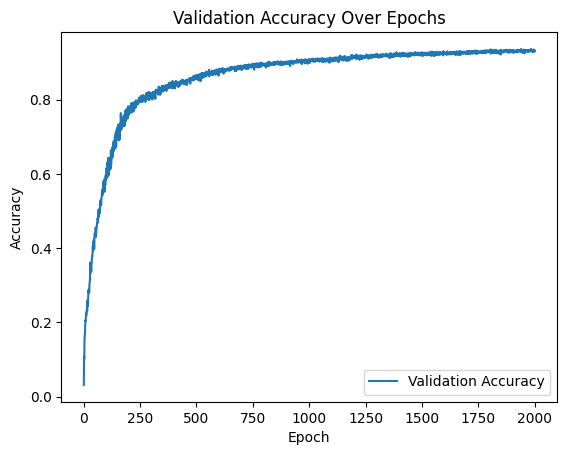

Evaluating the model on the test set...
Classification report for ground truth data:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94        72
           1       0.92      0.94      0.93        51
           2       0.94      0.89      0.92        55
           3       1.00      0.95      0.97        37
           4       1.00      1.00      1.00        49
           5       0.98      0.91      0.94        46
           6       0.86      0.94      0.90        32
           7       0.88      0.98      0.93        53
           8       0.95      0.97      0.96        38
           9       0.94      0.96      0.95        49
          10       0.98      1.00      0.99        43
          11       1.00      1.00      1.00        42
          12       0.97      0.97      0.97        38
          13       0.89      0.85      0.87        40
          14       0.88      0.68      0.77        34
          15       0.93      1.00      0.96       

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm


# Define the MLP model
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=1000, hidden_dim=100, output_dim=13):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Extract features and labels from ground truth data
print("Extracting features and labels from ground truth data...")
X_gt = pca_gt_adata.obsm['X_umap']
y_gt = pca_gt_adata.obs['leiden'].astype('category').cat.codes.values

# Split the ground truth data into training, validation, and testing sets
print("Splitting the ground truth data into training, validation, and testing sets...")
X_train, X_temp, y_train, y_temp = train_test_split(X_gt, y_gt, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert data to PyTorch tensors
print("Converting data to PyTorch tensors...")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for training and validation data
print("Creating DataLoader for training and validation data...")
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Initialize the model, loss function, and optimizer
print("Initializing the model, loss function, and optimizer...")
input_dim = X_train.shape[1]
hidden_dim = 100
output_dim = len(set(y_gt))
model = MLPClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

# Train the model
print("Training the model...")
num_epochs = 2000
model.train()
from tqdm import tqdm, trange

import matplotlib.pyplot as plt

training_losses = []
validation_losses = []
validation_accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    training_losses.append(epoch_loss / len(train_loader))
    
    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    validation_losses.append(val_loss / len(val_loader))
    validation_accuracies.append(correct / total)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {correct/total:.4f}")

# Plot training and validation loss in log scale
plt.figure()
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Log Scale)')
plt.yscale('log')
plt.title('Training and Validation Loss Over Epochs (Log Scale)')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure()
plt.plot(range(1, num_epochs + 1), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Evaluate the model on the test set
print("Evaluating the model on the test set...")
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, y_pred = torch.max(outputs, 1)
    print("Classification report for ground truth data:")
    report_dict = classification_report(y_test, y_pred.numpy(), output_dict=True)
    test_accuracy = report_dict['accuracy']
    print(classification_report(y_test, y_pred.numpy()))



# Save the classifier
classifier_save_dir = os.path.join("/gpfs/radev/scratch/dijk/sh2748/calmflow_singlecell/leiden_classifier_model", pert_split)
os.makedirs(classifier_save_dir, exist_ok=True)
classifier_save_path = os.path.join(classifier_save_dir, f"trained_classifier_on_GT_Leiden_resol{leiden_resol}_Test_Acc{test_accuracy:.2f}.pth")
torch.save(model.state_dict(), classifier_save_path)
print(f"Classifier saved to {classifier_save_path}")
